## Looking at the poll data

In [2]:
# polls are inside italian_polls.jsonl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


polls = pd.read_json('italian_polls.jsonl', lines=True)

C:\Users\rmlaz\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Checks

In [8]:
## are there duplicates? exclude column row
polls.duplicated(subset=polls.columns.difference(['row'])).sum()

0

In [12]:
# see if some values are negative, only consider columns with numeric values

polls[polls.select_dtypes(include=[np.number]).lt(0).any(axis=1)]

,Row,Data Inserimento,Realizzatore,Committente,Titolo,text,domanda,national_poll_rationale,national_poll,Partito Democratico,...,Stati Uniti d'Europa,Pace Terra Dignità,Azione - Italia Viva,Azione/+Europa,Sinistra Ecologia Libertà,Scelta Civica,Unione di Centro,Sud Chiama Nord,Unione Popolare,Altri
680,9,19/07/2020,tecnè srl,agenzia dire,monitor italia,"lega -12,1%\nfratelli d'italia +9,4%\npd -3,4%...",un anno di consensi ai principali partiti \n(i...,"The poll includes major parties such as Lega, ...",1,-3.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.1


In [ ]:

# data inserimento is in the format 'dd/mm/yyyy'
# renaming Data Inserimento to date
polls = polls.rename(columns={'Data Inserimento': 'date'})
polls['date'] = pd.to_datetime(polls['date'], format='%d/%m/%Y')

# filtering out bad/unappropriate data - data where more than 3 parties have nan values
#polls = polls.dropna(thresh=2)

# columns after the 8th should be floats
# turning digit,1 into digit.1 and digit% into digit
polls.iloc[:, 8:] = polls.iloc[:, 8:].replace({',': '.'}, regex=True)
polls.iloc[:, 8:] = polls.iloc[:, 8:].replace({'%': ''}, regex=True)

# cast into float and discard the non castable values
polls.iloc[:, 8:] = polls.iloc[:, 8:].apply(pd.to_numeric, errors='coerce')



In [3]:
polls

,Row,date,Realizzatore,Committente,Titolo,text,domanda,national_poll_rationale,national_poll,Partito Democratico,...,Stati Uniti d'Europa,Pace Terra Dignità,Azione - Italia Viva,Azione/+Europa,Sinistra Ecologia Libertà,Scelta Civica,Unione di Centro,Sud Chiama Nord,Unione Popolare,Altri
0,1,2024-09-27,Euromedia Research,Rai. Porta a Porta,Intenzioni di voto,"FRATELLI D'ITALIA-GIORGIA MELONI 30,3\nPARTITO...",Se questa domenica ci fossero le elezioni poli...,The poll includes all major parties and refers...,1,23.5,...,NaN,0.8,NaN,NaN,NaN,NaN,NaN,0.4,NaN,3.2
1,1,2024-09-24,SWG spa,La7,intenzioni di voto,"FRATELLI D'ITALIA 30,1\nPARTITO DEMOCRATICO 22...",Se dovesse votare oggi alle elezioni nazionali...,The poll includes all major parties and refers...,1,22.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.5
2,3,2024-09-23,Quorum - Youtrend strategies,Sky TG24,Osservatorio Italia,Oggi Variazione rispetto al 2 settembre\nFrate...,Intenzioni di voto,The poll includes all major parties such as Fr...,1,23.5,...,NaN,0.7,NaN,NaN,NaN,NaN,NaN,0.6,NaN,2.4
3,4,2024-09-23,tecnè srl,agenzia dire,monitor italia,"Fdi 29,2%\npd 23,6%\nfi 11%\nm5s 10,9%\nlega 8...",il borsino dei partiti \nastensione/incerti 48...,The poll includes major parties such as Fratel...,1,23.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.1
4,13,2024-09-17,SWG spa,La7,intenzioni di voto,"FRATELLI D'ITALIA 30,3\nPARTITO DEMOCRATICO 22...",Se dovesse votare oggi alle elezioni nazionali...,The poll includes all major parties and refers...,1,22.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1,NaN,3.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387,6,2012-07-04,EMG,Telecom Italia Media - La7 TV,Intenzioni di voto per la Camera dei Deputati,• Federazione della Sinistra: 2.4% (2.6%) • I ...,SUPPONGA ORA DI ESSERE IN QUESTO MOMENTO NELLA...,The poll includes major parties such as Partit...,1,26.0,...,NaN,NaN,NaN,NaN,5.8,NaN,7.2,NaN,NaN,0.2
1388,9,2012-07-03,SpinCon,Quotidiano L'Opinione,Job approval ed intenzioni di voto,"{""PDL"": ""17,40%"", ""LEGA NORD"": ""6,70%"", ""DESTR...",Se ieri si fossero tenute le elezioni politich...,The poll includes several major parties such a...,1,25.5,...,NaN,NaN,NaN,NaN,6.1,NaN,6.0,NaN,NaN,0.9
1389,10,2012-07-03,SpinCon,Quotidiano L'Opinione,Job approval e intenzioni di voto,"{""PDL"": ""17,10%"", ""LEGA NORD"": ""6,80%"", ""DESTR...",Se ieri si fossero tenute le elezioni politich...,The poll includes major parties such as Partit...,1,26.2,...,NaN,NaN,NaN,NaN,5.9,NaN,5.3,NaN,NaN,1.0
1390,5,2012-07-02,SWG srl,osservatorio politico SWG,intenzioni di voto ed elezioni primarie,"{""RISPOSTE"": ""VALORI%"", ""Partito Democratico-P...",Se alle prossime elezioni politiche si present...,The poll includes several major parties such a...,1,23.2,...,NaN,NaN,NaN,NaN,5.4,NaN,6.8,NaN,NaN,19.2


In [24]:
# top 10 rows where pd has small values
polls.nsmallest(10, 'Partito Democratico')

,Row,date,Realizzatore,Committente,Titolo,text,domanda,national_poll_rationale,national_poll,Partito Democratico,...,Stati Uniti d'Europa,Pace Terra Dignità,Azione - Italia Viva,Azione/+Europa,Sinistra Ecologia Libertà,Scelta Civica,Unione di Centro,Sud Chiama Nord,Unione Popolare,Altri
680,9,2020-07-19,tecnè srl,agenzia dire,monitor italia,"lega -12,1%\nfratelli d'italia +9,4%\npd -3,4%...",un anno di consensi ai principali partiti \n(i...,"The poll includes major parties such as Lega, ...",1,-3.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.10
1181,1,2014-01-29,Scenaripolitici.com,Scenaripolitici.com,"Intenzioni di voto, Fiducia Letta, Il voto 200...",Partito: % Centrodestra (Berlusconi) - % Centr...,Indichi quale Coalizione ha votato alle Elezio...,The poll discusses voting percentages for vari...,1,2.00,...,NaN,NaN,NaN,NaN,1.0,48.0,68.0,NaN,NaN,49.00
268,2,2023-01-24,SWG spa,La7,intenzioni di voto,"FRATELLI D'ITALIA 30,8\nMOVIMENTO 5 STELLE 17,...",Se dovesse votare oggi alle elezioni nazionali...,The poll includes all major parties such as Fr...,1,14.00,...,NaN,NaN,8.2,NaN,NaN,NaN,NaN,NaN,1.8,2.50
275,3,2023-01-10,SWG spa,La7,intenzioni di voto,"FRATELLI D'ITALIA 31,3\nMOVIMENTO 5 STELLE 17,...",Se dovesse votare oggi alle elezioni nazionali...,The poll includes all major parties such as Fr...,1,14.00,...,NaN,NaN,7.5,NaN,NaN,NaN,NaN,NaN,1.6,2.50
264,9,2023-01-31,SWG spa,La7,intenzioni di voto,"FRATELLI D'ITALIA 30,4\nMOVIMENTO 5 STELLE 17,...",Se dovesse votare oggi alle elezioni nazionali...,The poll includes all major parties such as Fr...,1,14.20,...,NaN,NaN,8.2,NaN,NaN,NaN,NaN,NaN,2.0,2.80
271,6,2023-01-17,SWG spa,La7,intenzioni di voto,"FRATELLI D'ITALIA 31,3\nMOVIMENTO 5 STELLE 17,...",Se dovesse votare oggi alle elezioni nazionali...,The poll includes all major parties such as Fr...,1,14.20,...,NaN,NaN,7.8,NaN,NaN,NaN,NaN,NaN,1.8,2.60
278,11,2022-12-20,SWG spa,La7,intenzioni di voto,"FRATELLI D'ITALIA 30,6\nMOVIMENTO 5 STELLE 17,...",Se dovesse votare oggi alle elezioni nazionali...,The poll includes all major parties such as Fr...,1,14.70,...,NaN,NaN,7.8,NaN,NaN,NaN,NaN,NaN,1.8,3.60
845,2,2019-03-12,VENUM 3.0 SRL,AGEBAS SRL,INTENZIONI DI VOTO REGIONALI BASILICATA 2019,- Movimento 5 stelle 33.47%\n- Partito democra...,1) Alle elezioni Politiche del 4 marzo 2018 qu...,The poll includes major parties such as Movime...,1,14.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.38
262,1,2023-02-07,SWG spa,La7,intenzioni di voto,"FRATELLI D'ITALIA 30,6\nMOVIMENTO 5 STELLE 17,...",Se dovesse votare oggi alle elezioni nazionali...,The poll includes major parties such as Fratel...,1,14.80,...,NaN,NaN,8.1,NaN,NaN,NaN,NaN,NaN,2.0,5.40
1048,7,2015-09-15,Episteme s.r.l.,Episteme s.r.l.,Intenzioni di voto e la disaffezione dalla pol...,"{""Partito democratico"": ""15"", ""Forza Italia"": ...",Se domani si dovesse votare per eleggere il nu...,The poll includes major parties such as Partit...,1,15.00,...,NaN,NaN,NaN,NaN,2.9,0.2,0.3,NaN,NaN,2.40


In [18]:
lowest_pd

,Row,date,Realizzatore,Committente,Titolo,text,domanda,national_poll_rationale,national_poll,Partito Democratico,...,Stati Uniti d'Europa,Pace Terra Dignità,Azione - Italia Viva,Azione/+Europa,Sinistra Ecologia Libertà,Scelta Civica,Unione di Centro,Sud Chiama Nord,Unione Popolare,Altri
680,9,2020-07-19,tecnè srl,agenzia dire,monitor italia,"lega -12,1%\nfratelli d'italia +9,4%\npd -3,4%...",un anno di consensi ai principali partiti \n(i...,"The poll includes major parties such as Lega, ...",1,-3.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.1


In [5]:
# rows with text of less of 10 characters
problematic_rows = polls[polls['text'].str.len() < 10]
problematic_rows

,Row,date,Realizzatore,Committente,Titolo,text,domanda,national_poll_rationale,national_poll,Partito Democratico,...,Stati Uniti d'Europa,Pace Terra Dignità,Azione - Italia Viva,Azione/+Europa,Sinistra Ecologia Libertà,Scelta Civica,Unione di Centro,Sud Chiama Nord,Unione Popolare,Altri
457,9,2021-11-12,Sondaggi BiDiMedia,Associazione Bidimedia,Intenzioni di voto per fasce d'età,{},Se si votasse oggi per le ELEZIONI POLITICHE a...,The question refers to voting intentions for p...,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
550,10,2021-04-20,Sondaggi Bidimedia - Bi3,Sondaggi Bidimedia,DDL Zan ed intenzioni di voto per religiosità ...,{},Se si votasse oggi per le ELEZIONI POLITICHE a...,The question refers to voting intentions for p...,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
578,4,2021-03-03,Tecnè srl,agenzia dire,monitor italia 26/02/2021,,"il consenso ai principali \n\nlega 23,6% \npd ...",The poll includes all major parties such as Le...,1,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
894,6,2018-06-27,Istituto Piepoli,Istituto Piepoli,La politica del Governo sull'immigrazione; int...,{},INTENZIONI DI VOTO – CAMERA 2018 (VALORI %),The text refers to voting intentions for the 2...,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
897,13,2018-06-21,Istituto Piepoli,Istituto Piepoli,INTENZIONI DI VOTO - MIGRANTI - CORRUZIONE,{},INTENZIONI DI VOTO – CAMERA 2018 (VALORI %),The text refers to voting intentions for the 2...,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250,5,2013-07-19,Istituto Piepoli,Istituto Piepoli,Intenzioni di voto alla Camera.,{},INTENZIONI DI VOTO ALLA CAMERA - PARTITO E COA...,The text refers to voting intentions for the C...,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1260,13,2013-06-05,Istituto Piepoli,Istituto Piepoli,Intenzioni di voto alla Camera - 3 giugno 2013.,{},INTENZIONI DI VOTO ALLA CAMERA - 3 GIUGNO 2013:,The poll refers to voting intentions for the C...,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1268,2,2013-05-10,ISPO RICERCHE S.R.L.,RAI UNO - PORTA A PORTA,"INTENZIONI DI VOTO, IL GIUDIZIO SUL GOVERNO E ...",{},Se domani ci fossero le elezioni politiche lei...,The question is asking for voting intentions i...,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1278,5,2013-04-10,ISPO RICERCHE S.R.L.,RAI UNO - PORTA A PORTA,INTENZIONI DI VOTO,{},Se domani ci fossero le elezioni politiche lei...,The question is asking for voting intentions i...,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
problematic_rows.date.apply(lambda x: x.year).value_counts()

date
2015    42
2016    18
2014    17
2018    11
2013     6
2021     3
Name: count, dtype: int64

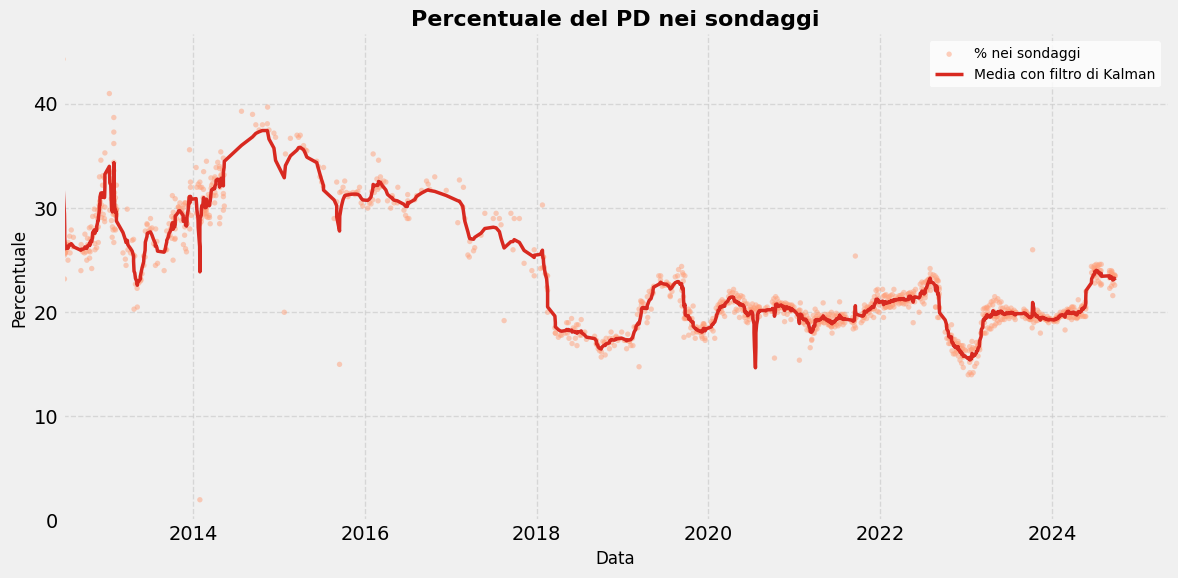

In [7]:
# plot PD vote over time
from pykalman import KalmanFilter
import matplotlib.dates as mdates

plt.style.use('fivethirtyeight')

# Prepare the data
pd_votes = polls[['date', 'Partito Democratico']]
pd_votes = pd_votes.set_index('date')
pd_votes = pd_votes.dropna()

# Convert to numpy array for Kalman filter
observations = pd_votes['Partito Democratico'].values

# Set up the Kalman Filter with less smoothing
kf = KalmanFilter(
    initial_state_mean=observations[0],
    initial_state_covariance=1.0,
    observation_covariance=0.5,  # Reduced from 0.5 for less smoothing
    transition_covariance=0.11,   # Increased from 0.1 for less smoothing
    transition_matrices=[1],
    observation_matrices=[1]
)

# Apply the Kalman Filter
state_means, _ = kf.smooth(observations)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the scatter points (smaller and light grey)
ax.scatter(pd_votes.index, pd_votes['Partito Democratico'], 
           color='lightsalmon', alpha=0.5, s=15, edgecolors='none', label='% nei sondaggi')

# Plot the Kalman filter line (red and slightly thicker)
ax.plot(pd_votes.index, state_means, 
        color='#d82920', linewidth=2.5, label='Media con filtro di Kalman')

# Customize the plot
ax.set_title('Percentuale del PD nei sondaggi', fontsize=16, fontweight='bold')
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Percentuale', fontsize=12)
ax.legend(fontsize=10, frameon=True, facecolor='white', edgecolor='none')   

# Set y-axis to start at 0
ax.set_ylim(bottom=0)

# Set x-axis to start at the first day of polling
ax.set_xlim(left=pd_votes.index[-1])

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.7, color='#CCCCCC')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout and display
plt.tight_layout()
plt.show()

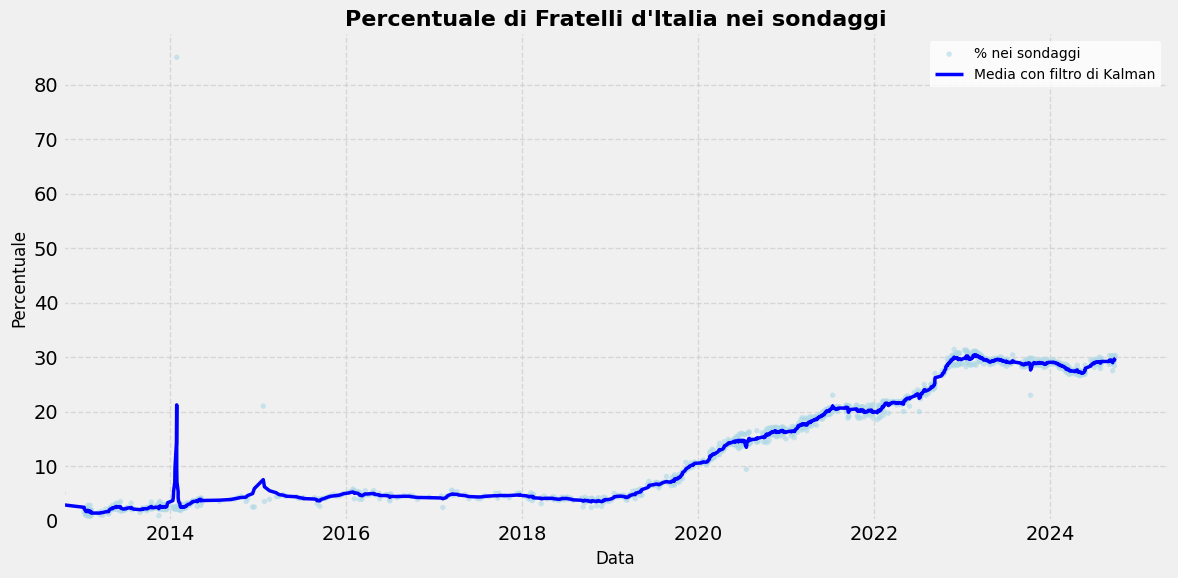

In [8]:
# same for Frateelli d'Italia

# Prepare the data
fdi_votes = polls[['date', 'Fratelli d\'Italia']]
fdi_votes = fdi_votes.set_index('date')
fdi_votes = fdi_votes.dropna()

# Convert to numpy array for Kalman filter

observations = fdi_votes['Fratelli d\'Italia'].values

# Set up the Kalman Filter with less smoothing

kf = KalmanFilter(
    initial_state_mean=observations[0],
    initial_state_covariance=1.0,
    observation_covariance=0.5,  # Reduced from 0.5 for less smoothing
    transition_covariance=0.11,   # Increased from 0.1 for less smoothing
    transition_matrices=[1],
    observation_matrices=[1]
)

# Apply the Kalman Filter

state_means, _ = kf.smooth(observations)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the scatter points (smaller and light blue)

ax.scatter(fdi_votes.index, fdi_votes['Fratelli d\'Italia'],
                      color='lightblue', alpha=0.6, s=15, edgecolors='none', label='% nei sondaggi')

ax.plot(fdi_votes.index, state_means,
        color='blue', linewidth=2.5, label='Media con filtro di Kalman')

# Customize the plot

ax.set_title('Percentuale di Fratelli d\'Italia nei sondaggi', fontsize=16, fontweight='bold')

ax.set_xlabel('Data', fontsize=12)

ax.set_ylabel('Percentuale', fontsize=12)

ax.legend(fontsize=10, frameon=True, facecolor='white', edgecolor='none')

# Set y-axis to start at 0

ax.set_ylim(bottom=0)

# Set x-axis to start at the first day of polling

ax.set_xlim(left=fdi_votes.index[-1])

# Add gridlines

ax.grid(True, linestyle='--', alpha=0.7, color='#CCCCCC')

# Remove top and right spines

ax.spines['top'].set_visible(False)

ax.spines['right'].set_visible(False)

# Adjust layout and display

plt.tight_layout()

plt.show()

In [9]:
# both of them in one plot with y axis capped at 50

# pd_votes and fdi_votes are already prepared

# pd_votes and fdi_votes should have the same length
assert len(pd_votes) == len(fdi_votes)

# 2 kalman filters
observations_pd = pd_votes['Partito Democratico'].values
observations_fdi = fdi_votes['Fratelli d\'Italia'].values



# from obs, get index of big jumps so we can remove them
def get_big_jumps(obs):
    jumps = []
    for i in range(1, len(obs)):
        if abs(obs[i] - obs[i - 1]) > 2:
            jumps.append(i)
    return jumps

# get the jumps

jumps_pd = get_big_jumps(observations_pd)
jumps_fdi = get_big_jumps(observations_fdi)

# remove the jumps

for jump in jumps_pd:
    observations_pd[jump] = np.nan
    observations_fdi[jump] = np.nan

# the dataframes should be adapted to the new observations
pd_votes['Partito Democratico'] = observations_pd
fdi_votes['Fratelli d\'Italia'] = observations_fdi

# remove the nans
pd_votes = pd_votes.dropna()
fdi_votes = fdi_votes.dropna()

# count nan values
assert pd_votes.isnull().sum().sum() == 0
assert fdi_votes.isnull().sum().sum() == 0

# also from the observations
observations_pd = pd_votes['Partito Democratico'].values
observations_fdi = fdi_votes['Fratelli d\'Italia'].values
    
# len fdi_votes and pd_votes should be the same
assert len(fdi_votes) == len(pd_votes)
assert len(observations_pd) == len(observations_fdi)
assert len(observations_pd) == len(pd_votes)


print(len(observations_pd), len(observations_fdi), len(pd_votes), len(fdi_votes))
kf_pd = KalmanFilter(
    initial_state_mean=observations_pd[0],
    initial_state_covariance=1.0,
    observation_covariance=0.5,  # Reduced from 0.5 for less smoothing
    transition_covariance=0.11,   # Increased from 0.1 for less smoothing
    transition_matrices=[1],
    observation_matrices=[1]
)

kf_fdi = KalmanFilter(
    initial_state_mean=observations_fdi[0],
    initial_state_covariance=1.0,
    observation_covariance=0.5,  # Reduced from 0.5 for less smoothing
    transition_covariance=0.11,   # Increased from 0.1 for less smoothing
    transition_matrices=[1],
    observation_matrices=[1]
)

state_means_pd, _ = kf_pd.smooth(observations_pd)

state_means_fdi, _ = kf_fdi.smooth(observations_fdi)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the scatter points with same colors from before

ax.scatter(pd_votes.index, pd_votes['Partito Democratico'],
           color='lightsalmon', alpha=0.5, s=15, edgecolors='none', label='% PD nei sondaggi')

ax.scatter(fdi_votes.index, fdi_votes['Fratelli d\'Italia'],
           color='lightblue', alpha=0.6, s=15, edgecolors='none', label='% FDI nei sondaggi')

# Plot the Kalman filter lines with same colors from before

ax.plot(pd_votes.index, state_means_pd,
        color='#d82920', linewidth=2.5, label='Media PD con filtro di Kalman')

ax.plot(fdi_votes.index, state_means_fdi,
        color='blue', linewidth=2.5, label='Media FDI con filtro di Kalman')

# Customize the plot

ax.set_title('Percentuali nei sondaggi', fontsize=16, fontweight='bold')

ax.set_xlabel('Data', fontsize=12)

ax.set_ylabel('Percentuale', fontsize=12)

ax.legend(fontsize=10, frameon=True, facecolor='white', edgecolor='none')

# Set y-axis to start at 0 and cap at 50

ax.set_ylim(bottom=0, top=50)

# Set x-axis to start at the first day of polling

ax.set_xlim(left=pd_votes.index[-1])

# Add gridlines

ax.grid(True, linestyle='--', alpha=0.7, color='#CCCCCC')

# Remove top and right spines

ax.spines['top'].set_visible(False)

ax.spines['right'].set_visible(False)

# Adjust layout and display

plt.tight_layout()

plt.show()

AssertionError: 

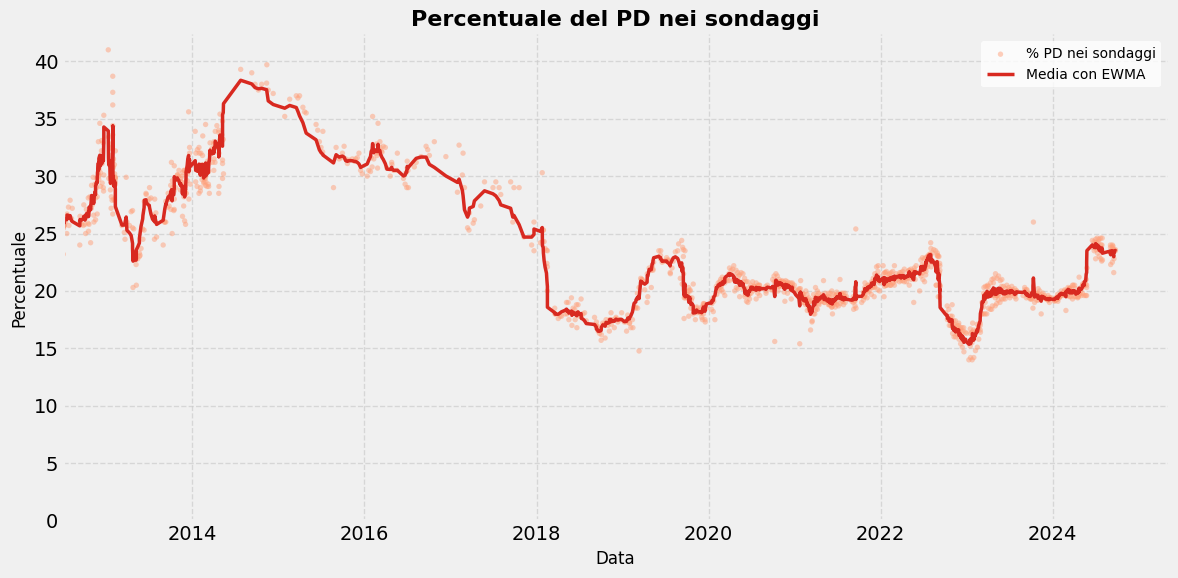

In [60]:
# stessa cosa ma usando l'exponentially weighted moving average

# Prepare the data

pd_votes = polls[['date', 'Partito Democratico']]

pd_votes = pd_votes.set_index('date')

pd_votes = pd_votes.dropna()

# remove big outliers, where pd_votes is more than 2% different from the previous value
pd_votes['diff'] = pd_votes['Partito Democratico'].diff()
pd_votes = pd_votes[abs(pd_votes['diff']) < 10]

# Calculate the exponentially weighted moving average
pd_votes['ewma'] = pd_votes['Partito Democratico'].ewm(span=7,adjust=False).mean()

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the scatter points (smaller and light grey)

ax.scatter(pd_votes.index, pd_votes['Partito Democratico'],
              color='lightsalmon', alpha=0.5, s=15, edgecolors='none', label='% PD nei sondaggi')

# Plot the exponentially weighted moving average line (red and slightly thicker)

ax.plot(pd_votes.index, pd_votes['ewma'],
        
        color='#d82920', linewidth=2.5, label='Media con EWMA')

# Customize the plot

ax.set_title('Percentuale del PD nei sondaggi', fontsize=16, fontweight='bold')

ax.set_xlabel('Data', fontsize=12)

ax.set_ylabel('Percentuale', fontsize=12)

ax.legend(fontsize=10, frameon=True, facecolor='white', edgecolor='none')

# Set y-axis to start at 0

ax.set_ylim(bottom=0)

# Set x-axis to start at the first day of polling

ax.set_xlim(left=pd_votes.index[-1])

# Add gridlines

ax.grid(True, linestyle='--', alpha=0.7, color='#CCCCCC')

# Remove top and right spines

ax.spines['top'].set_visible(False)

ax.spines['right'].set_visible(False)

# Adjust layout and display

plt.tight_layout()

plt.show()

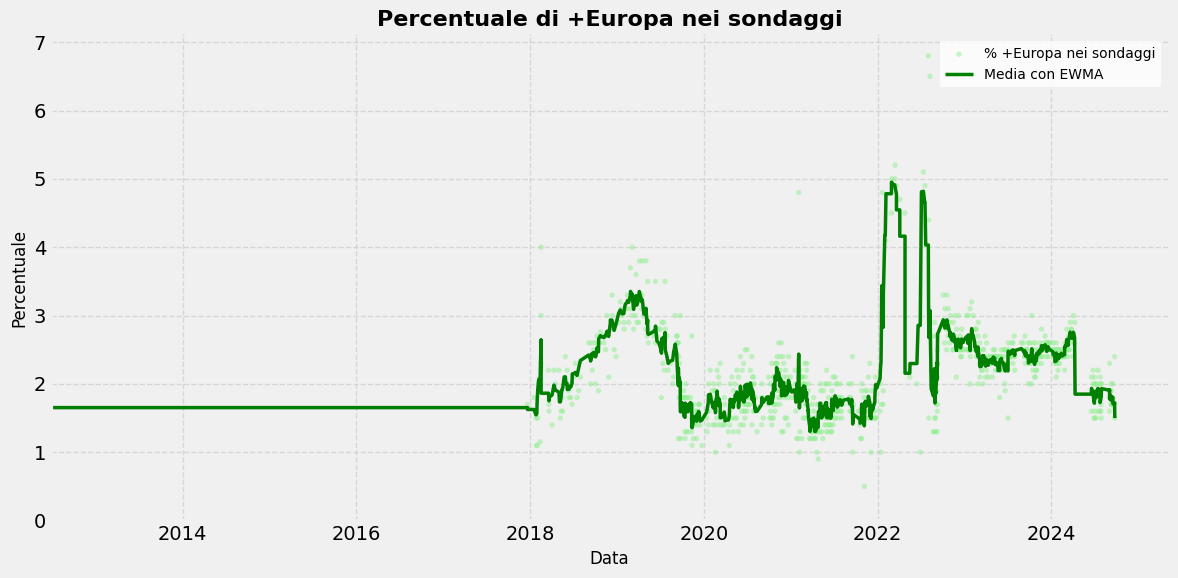

In [58]:
# investigating gaps in the data

# plot +europa ewm 

# Prepare the data

europa_votes = polls[['date', '+Europa']]

europa_votes = europa_votes.set_index('date')


# Calculate the exponentially weighted moving average

europa_votes['ewma'] = europa_votes['+Europa'].ewm(span=7, adjust=False).mean()

# Find the indices where there are NaN values
nan_indices = europa_votes['+Europa'].isnull()

# Plot the scatter points with breaks on NaN values
ax.scatter(europa_votes.index[~nan_indices], europa_votes['+Europa'][~nan_indices],
           color='lightgreen', alpha=0.5, s=15, edgecolors='none', label='% +Europa nei sondaggi')

# Plot the scatter points with breaks on NaN values
ax.scatter(europa_votes.index[nan_indices], europa_votes['+Europa'][nan_indices],
           color='lightgreen', alpha=0.5, s=15, edgecolors='none', label='% +Europa nei sondaggi')

# Plot the exponentially weighted moving average line (green and slightly thicker)
ax.plot(europa_votes.index, europa_votes['ewma'],
        color='green', linewidth=2.5, label='Media con EWMA')

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the scatter points (smaller and light grey)

ax.scatter(europa_votes.index, europa_votes['+Europa'],

              color='lightgreen', alpha=0.5, s=15, edgecolors='none', label='% +Europa nei sondaggi')

# Plot the exponentially weighted moving average line (green and slightly thicker)

ax.plot(europa_votes.index, europa_votes['ewma'],
            
            color='green', linewidth=2.5, label='Media con EWMA')

# Customize the plot

ax.set_title('Percentuale di +Europa nei sondaggi', fontsize=16, fontweight='bold')

ax.set_xlabel('Data', fontsize=12)

ax.set_ylabel('Percentuale', fontsize=12)

ax.legend(fontsize=10, frameon=True, facecolor='white', edgecolor='none')

# Set y-axis to start at 0

ax.set_ylim(bottom=0)

# Set x-axis to start at the first day of polling

ax.set_xlim(left=europa_votes.index[-1])

# Add gridlines

ax.grid(True, linestyle='--', alpha=0.7, color='#CCCCCC')

# Remove top and right spines

ax.spines['top'].set_visible(False)

ax.spines['right'].set_visible(False)

# Adjust layout and display

plt.tight_layout()

plt.show()
    